In [21]:
from langchain_google_genai import ChatGoogleGenerativeAI # thư viện chính để sử dụng Google Generative AI
from dotenv import find_dotenv, load_dotenv # thư viện để load biến môi trường từ file .env
from langchain.prompts.chat import (
    HumanMessagePromptTemplate,
    ChatPromptTemplate
) # phục vụ cho việc tạo prompt
from pydantic import BaseModel, Field # thư viện để định nghĩa kiểu dữ liệu
from langchain.output_parsers import PydanticOutputParser # thư viện để phân tích đầu ra từ mô hình
from typing import Optional # Giúp xử lí các kiểu dữ liệu tùy chọn, ví dụ Optional[str] có thể là str hoặc None
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
import getpass
import time
import json
import warnings

In [22]:
#Bỏ qua cảnh báo FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# GIAI ĐOẠN 1: TẠO PROMPT VÀ ĐIỀU CHỈNH NỘI DUNG PHÙ HỢP, ÁP DỤNG CÁC KĨ THUẬT ONE-SHOT VÀ FEW-SHOT PROMPTING


In [ ]:
#Tạo 1 class để định nghĩa các thông tin đầu vào và đầu ra cho việc lấy thông tin tuyển dụng
class Recruiment_Info(BaseModel):
    #Lấy tên công việc
    Job_Title: Optional[str] = Field(description="Lấy đầy đủ tên công việc, chính xác từng chữ trong yêu cầu tuyển dụng, chỉ lấy thông tin liên quan đến tên công việc, tuyệt đối không đưa các thông tin liên quan đến các nội dung sau vào mục Job_Title:" \
        "Số năm kinh nghiệm, " \
        "Mức lương hay thông tin về thưởng thêm, phụ cấp, " \
        "Ngoại ngữ yêu cầu ví dụ như tiếng Anh, tiếng Trung,... " \
        "Địa điểm, thành phố, quốc gia, tuyển dụng ví dụ như Hồ Chí Minh,... " \
        "Thông tin về ngày nghỉ, ngày làm việc trong tuần (ví dụ Nghỉ Thứ 7 - Chủ Nhật) (Sử dụng thông tin ngày nghỉ này để điền cho các trường liên quan đến việc có đi làm thứ 7 hay Chủ Nhật không), " \
        "Ngoài các thông tin trên, hãy giữ lại đầy đủ tên công việc và thông tin liên quan đến vị trí công việc đó, ví dụ: Senior BA (Gaming/Social/Metaverse) thì vẫn giữ là Senior BA (Gaming/Social/Metaverse)" \
        "Sau đó, viết hoa chữ cái đầu tiếng Việt, tiếng Anh thì viết hoa tên công việc, ví dụ: lập trình viên backend Developer (Golang Từ 2 Năm Kinh Nghiệm, 20 - 25 Triệu/Tháng, Tiếng Anh, Hồ Chí Minh, Nghỉ Thứ 7 - Chủ Nhật, Thu Nhập Hấp Dẫn) chuyển thành duy nhất thông tin liên quan đến nghề nghiệp và chuyên môn là: Lập trình viên Backend Developer")

    #Lấy tất cả Tech Stack
    Tech_Stack: Optional[list] = Field(default =[""],description="Lấy chính xác, nhất quán tên chính thức của tất cả các Tech Stack, tên các thuật ngữ chuyên môn được yêu cầu (Mobile, Web, Docker,Database Management System,...) và các công nghệ, phương pháp lập trình OOP, skills, tools, môn học như toán (Đại Số, Xác Suất Thống Kê), hệ quản trị cơ sở dữ liệu như MySQL, SQL Sever,PostgreSQL, vân vân... (nếu có), không điền ngôn ngữ truy vấn SQL vào mục này vì nó thuộc mục 'Programming_Language', viết hoa toàn bộ chữ cái, đề nghị quy chuẩn hết về 1 tên gọi (Không được trả về 1 câu) chính thức của công nghệ và tools được tìm thấy, ví dụ thông tin có đề cập đến việc sử dụng Docker thì trả về đúng tên Tech Stack là Docker, tương tự với các Tech Stack khác, Nếu không có thông tin thì trả về danh sách rỗng")

    #Lấy tất cả tên ngôn ngữ lập trình/truy vấn
    Programming_Language: Optional[list] = Field(default =[""],description="Lấy chính xác, nhất quán tên chính thức của tất cả tên ngôn ngữ lập trình,ví dụ thông tin có đề cập đến việc sử dụng Python, C++, Java thì trả về đúng tên ngôn ngữ lập trình là PYTHON, C++, JAVA, tương tự với các ngôn ngữ lập trình khác, viết hoa toàn bộ chữ cái, nếu thông tin có đề cập đến các hệ quản trị cơ sở dữ liệu 'SQL' hoặc 'NoSQL' thì hãy suy luận ra và bổ sung thêm trong kết quả trả về. Ví dụ thông tin có đề cập đến SQL Sever thì thêm SQL vào kết quả trả về, nếu có có đề cập MongoDB thì thêm NOSQL từ kết quả trả về, nếu có cả hai thì bổ sung cả hai vào kết quả trả về. Các Database Management System/ Hệ quản trị cơ sở dữ liệu ví dụ như PostgreSQL, SQL Sever, MySQL, vân vân.. nếu có trong Tech Stack được yêu cầu thì tuyệt đối không được để ở Programming Language để tránh trùng lặp. Nếu không có thông tin thì trả về danh sách rỗng")

    #Lấy ngày bắt đầu đi làm trong tuần
    First_Working_Day_Of_Week: Optional[int] = Field(default = None,description="""Dựa vào Time_Range, Benefits và Job_Title để lấy chính xác thứ bắt đầu trong tuần làm việc,ví dụ: 2, chú ý thông tin về ngày đi làm có thể được viết bằng tiếng Anh, nếu ngày đi làm trong tuần bắt đầu từ chủ Nhật hay thứ Bảy thì vẫn phải đưa về giá trị 2 (tức thứ Hai do đang xét ngày trong tuần (thứ Hai đến thứ Sáu) để nhất quán dữ liệu),ví dụ Chủ Nhật - Thứ 5, hoặc Thứ Bảy - Thứ 4. Còn Chủ Nhật là ngày đi làm cuối cùng trong tuần ví dụ thứ 4 - Chủ Nhật thì bạn trả về kết quả là 4 do ngày đi làm trong tuần bắt đầu từ thứ 4. Ví dụ thời gian làm việc là 5 ngày/tuần (nghỉ T7, CN) thì bạn có thể sử dụng phương pháp loại trừ để suy luận kết quả trả về là 2 (Tức là thứ 2), áp dụng cho các trường hợp tương tự. Nếu không có thông tin về ngày đi làm trong tuần thì trả về giá trị None
    """)

    #Lấy ngày cuối cùng đi làm trong tuần
    Last_Working_Day_Of_Week: Optional[int] = Field(default = None, description="""
    Dựa vào Time_Range, Benefits và Job_Title để lấy chính xác thứ cuối cùng đi làm trong tuần làm việc,ví dụ: nếu ghi là thứ 2 - thứ 6 thì trả về 6, thứ 2 - thứ 7 thì vẫn trả về 6, ví dụ thứ 4 - Chủ Nhật thì tức là Chủ Nhật có đi làm, trong trường hợp này vẫn trả về 6 do đang xét ngày trong tuần để trả về giá trị cho cột Last_Working_Day_Of_Week, thông tin về ngày đi làm có thể được viết bằng tiếng Anh. 
    Ví dụ thời gian làm việc là 5 ngày/tuần (nghỉ T7, CN) thì bạn có thể sử dụng phương pháp loại trừ để suy luận kết quả trả về là 6 (Tức là thứ 6), áp dụng cho các trường hợp tương tự.
    Chú ý các trường hợp sau:
    + Trường hợp 1: Nếu không có thông tin về ngày đi làm trong tuần(ví dụ từ thứ 2 - thứ 6) 
    + Trường hợp 2: Nếu chỉ có thông tin ngày nghỉ ví dụ như thứ 7 - Chủ Nhật 
    Nếu gặp 1 trong 2 trường hợp trên hoặc gặp cả 2 trường hợp trên thì bắt buộc trả về giá trị rỗng None vì không có thông tin cụ thể ngày nào đi làm, tuyệt đối không được ghi giá trị số khác thay thế nếu không liên quan đến thông tin thứ đi làm trong 1 tuần trong Time Range và Benefits.
    """)

    #Kiểm tra có đi làm thứ 7 hay không?
    Work_On_Saturday: Optional[bool] = Field(default = None,description="Dựa vào Time_Range, Benefits và Job_Title để lấy chính xác thông tin có đi làm thứ 7 (T7) hay không,nếu có thì trả về 1, nếu không thì trả về 0. Ví dụ làm việc thứ 2 - Chủ Nhật thì có nghĩa là có đi làm thứ 7, trả về giá trị là 1, các trường hợp có liên quan tới khoảng như vậy xử lí tương tự. Ví dụ: Nghỉ thứ 7 - Chủ Nhật hoặc nội dung nghỉ liên quan thì trả về 0, mặc định nếu chỉ có ngày làm việc cụ thể (Ví dụ Thứ 2 - Thứ 6 (từ 08:00 đến 17:00) và không đề cập gì tới Thứ 7) thì trả về 0, còn lại nếu không có thông tin gì về ngày làm việc trong tuần thì trả về giá trị None")

    #Kiểm tra có đi làm Chủ Nhật hay không?
    Work_On_Sunday: Optional[bool] = Field(default = None,description="Dựa vào Time_Range, Benefits và Job_Title để lấy chính xác thông tin có đi làm Chủ Nhật hay không,nếu có thì trả về 1, nếu không thì trả về 0. Ví dụ: làm việc thứ 4 - Chủ Nhật thì cột Work_On_Saturday và Work_On_Sunday trả về 1 trong trường hợp này. Ví dụ: Nghỉ thứ 7 (T7) - Chủ Nhật (CN) hoặc nội dung nghỉ liên quan đến 2 ngày này trong tuần thì trả về 0, mặc định nếu chỉ có ngày làm việc cụ thể (Ví dụ Thứ 2 - Thứ 6 (từ 08:00 đến 17:00), và không đề cập gì tới Chủ Nhật) thì trả về 0, còn lại nếu không có thông tin gì về ngày làm việc trong tuần thì trả về giá trị NaN")


    #Lấy tổng số giờ làm việc trong tuần --> Không thể nêu cụ thể giờ đi làm và giờ ra về vì có thể thay đổi theo từng ngày trong tuần, vì vậy chỉ có thể lấy tổng số giờ làm việc trong tuần
    Total_Work_Hour: Optional[float] = Field(default = None, description="""
    Bạn là một hệ thống trích xuất thông tin từ nội dung tuyển dụng IT. Nhiệm vụ của bạn là xác định tổng số giờ làm việc trong 1 tuần, dựa trên dữ liệu trong trường "Time_Range" (ưu tiên), nếu không có thì dùng "Benefits". Hãy quy đổi toàn bộ giờ làm việc về đơn vị giờ (float). Bỏ qua thời gian nghỉ trưa hoặc các khoảng nghỉ khác để tránh phức tạp hóa logic.

    Dưới đây là một số ví dụ:

    ---

    Ví dụ 1:
    Time_Range: Thứ 2 - Thứ 6 làm việc từ 08:00 sáng đến 18:15 tối, thứ 7 làm việc từ sáng 9:00 - 12:00 trưa  
    ⟶ Tổng số giờ làm việc trong 1 ngày (Thứ 2 - Thứ 6): `18.25 - 8 = 10.25 giờ`  
    ⟶ Tổng cho 5 ngày: `10.25 × 5 = 51.25 giờ`  
    ⟶ Thứ 7: `12 - 9 = 3 giờ`  
    ⟶ Kết quả: `54.25`

    ---

    Ví dụ 2:
    Time_Range: Thứ 2 - Thứ 6 (từ 08:30 đến 18:00)  
    ⟶ Tổng mỗi ngày: `18 - 8.5 = 9.5 giờ`  
    ⟶ Tổng tuần: `9.5 × 5 = 47.5`  
    ⟶ Kết quả: `47.5`

    ---

    Ví dụ 3:
    Time_Range: Thứ 2 - Thứ 6 (08:30 - 18:00), Thứ 7 (08:30 - 12:00)  
    ⟶ Thứ 2 - 6: `(18 - 8.5) × 5 = 47.5`  
    ⟶ Thứ 7: `12 - 8.5 = 3.5`  
    ⟶ Kết quả: `51.0`


    ---

    Ví dụ 4:
    Time_Range: Làm việc 5.5 ngày từ thứ 2 đến sáng thứ 7 (Và các trường hợp không rõ ràng như vậy)  
    ⟶ Không có thông tin cụ thể về giờ  
    ⟶ Kết quả: `None`

    ---

    Ví dụ 5:                                      
    Time_Range: Thứ 2 - Thứ 5 (từ 08:00 đến 18:00) Thứ 6 (từ 08:00 đến 17:00)

    ⟶ Thứ 2 - 5: `18 - 8 = 10 giờ`
    ⟶ Thứ 6: `17 - 8 = 9 giờ`
    ⟶ Tổng số giờ làm việc trong tuần: `10 × 4 + 9 = 49 giờ`

    Với các trường hợp khác, bạn hãy trả về kết quả về tổng số giờ làm việc như cách các ví dụ đã minh họa.Chú ý nếu không có thông tin về đơn vị giờ làm việc rõ ràng để tính toán như các ví dụ trên thì trả về giá trị là None.
    """)

    #Lấy tên công ty
    Province: Optional[list] = Field(default = [""],description="Lấy chính xác tất cả tên tỉnh thành được đề cập, ví dụ: Hà Nội, Thành phố Hồ Chí Minh, hoặc nếu không có tỉnh thành cụ thể mà chỉ ghi là 'Nước ngoài' thì hãy trả kết quả về là 'Nước ngoài'. Trả về giá trị là danh sách rỗng nếu không có thông tin về tỉnh thành trong yêu cầu tuyển dụng")
    
    #Lấy mức lương tối thiểu
    Salary_Min: Optional[float] = Field(default = None, description="Ưu tiên dựa vào trường 'Salary' (nếu không có thì dựa vào trường 'Benefits') để lấy chính xác mức lương tối thiểu, đơn vị đổi hết về VNĐ, 1 triệu thì đổi thành 1000000, nếu thông tin chỉ đề cập đến mức lương tối đa (ví dụ: Tới 55,000 USD hoặc tới 50 triệu) hoặc không có thông tin đề cập hoặc ghi là 'Thỏa thuận' thì trả về giá trị là NaN")

    #Lấy mức lương tối đa
    Salary_Max: Optional[float] = Field(default = None, description="Ưu tiên dựa vào trường 'Salary' (nếu không có thì dựa vào trường 'Benefits') để lấy chính xác mức lương tối đa,đơn vị đổi hết về VNĐ, 1 triệu thì đổi thành 1000000,nếu thông tin chỉ đề cập đến mức lương tối thiểu (ví dụ: từ 16 triệu hoặc từ 2,000 USD) hoặc không có thông tin đề cập hoặc ghi là 'Thỏa thuận' thì trả về giá trị là NaN")

    #Lấy số lượng tuyển dụng
    Recruitment_Count : Optional[int] = Field(default = 1, description="Lấy chính xác số lượng tuyển dụng, ví dụ 1,2, nếu không có thông tin thì trả về giá trị là 1")

    #Lấy thông tin ngoại ngữ làm việc
    Language: Optional[list] = Field(default = [""], description="Dựa vào địa điểm nơi làm việc, xác định ngôn ngữ đầu tiên. Sau đó trích ra thêm các ngoại ngữ yêu cầu dựa vào description và skills, nếu nhà tuyển dụng có yêu cầu thì mới liệt kê, bỏ các thông tin phụ, chú ý không dựa vào benefits để lấy thông tin ngoại ngữ yêu cầu, ví dụ: tiếng Việt, tiếng Anh")


In [24]:
#Kiểm tra xem biến môi trường có tồn tại không
dotenv_path = find_dotenv()
if dotenv_path:
    print(load_dotenv(dotenv_path)) # Tìm thấy file .env và load biến môi trường từ đó

#Nếu API_KEY(biến môi trường) không tồn tại, yêu cầu người dùng nhập vào
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")


True


In [25]:
google_api_key_str = os.getenv("GOOGLE_API_KEY") #Lấy API key từ biến môi trường
GOOGLE_API_KEY = json.loads(google_api_key_str) #Chuyển đổi chuỗi JSON thành danh sách Python
if GOOGLE_API_KEY:
    print("GOOGLE_API_KEY found in environment variables.")
    # print("GOOGLE_API_KEY: ", GOOGLE_API_KEY) # In ra API key để kiểm tra
else:
    print("GOOGLE_API_KEY not found in environment variables")
    exit(1)

GOOGLE_API_KEY found in environment variables.


In [26]:
#Chọn Model
Gemini_Model = 'gemini-2.0-flash' 

In [27]:
#Nhập yêu cầu prompt
PROMPT = """
        Bạn là một chuyên gia trích xuất thông tin.
        Bạn sẽ nhận dữ liệu về các thông tin cụ thể trong một yêu cầu tuyển dụng của 1 công việc thuộc lĩnh vực Công nghệ Thông tin hoặc ngành nghề có liên quan, và được tôi yêu cầu trích xuất thông tin cụ thể từ nó.
        Chú ý, nếu dữ liệu bị thiếu ở trường nào đó thì dựa vào kiểu dữ liệu đã định nghĩa trong class Recruiment_Info để trả về giá trị thiếu tương ứng đã quy định cho trường đó.
        Sau đây là yêu cầu tuyển dụng, bạn hãy trích xuất các thông tin được yêu cầu nhé!
        Yêu cầu khi bạn trích ra tên các Tech_Stack, Programming_Language thì hãy sử dụng tên nhất quán của các công nghệ, ngôn ngữ lập trình, thuật ngữ chuyên môn, nếu có nhiều tên gọi khác nhau thì hãy chọn 1 tên gọi chính thức nhất để sử dụng nhằm tạo độ nhất quán cho tên các công nghệ,thuật ngữ chuyên môn, tránh hiện tượng 1 Tech_Stack hay một kĩ năng được gọi và trả về kết quả là nhiều tên gọi khác nhau.
        {input_text}
        {format_instructions}
"""

In [28]:
def extract_info(row_of_data_frame, API_KEY):
    #Kiểm tra try except lỗi 429, hết quota
    try:
        llm = ChatGoogleGenerativeAI(api_key=API_KEY, model=Gemini_Model)
        # Set up a parser + inject instructions into the prompt template.
        parser = PydanticOutputParser(pydantic_object=Recruiment_Info) # Tạo parser từ class Recruiment_Info

        message = HumanMessagePromptTemplate.from_template(template=PROMPT) # Tạo template cho yêu cầu
        chat_prompt = ChatPromptTemplate.from_messages(messages=[message]) # Tạo prompt từ template
        chat_prompt_with_values = chat_prompt.format_prompt(input_text = row_of_data_frame, 
                                                            format_instructions = parser.get_format_instructions()) # Tạo prompt với giá trị cụ thể từ dòng dữ liệu, tham số input_text xuất hiện là vì được tạo ở phần "Nhập yêu cầu prompt", sẽ được thay thế bằng giá trị cụ thể từ dòng dữ liệu trong DataFrame, format_instructions là hướng dẫn định dạng đầu ra từ parser
        
        #Nhận và trả về kết quả từ LLM
        result = llm.invoke(chat_prompt_with_values.to_messages())
        data = parser.parse(result.content)

        #In ra kết quả, sử dụng model_dumpy để in ra các giá trị trong dictionary
        # print("Kết quả trích xuất thông tin:")
        # for key, value in data.model_dump().items():
        #     print(f"{key}: {value}")
    except Exception as e:
        print(f"Lỗi: {e}")
        return None
    return data.model_dump() # Trả về kết quả dưới dạng dictionary

In [29]:
data_original = pd.read_csv(r'D:\Python_code\DS108_Đồ_án\API_code\4186_records_data_bronze.csv') # Đọc dữ liệu từ file CSV vào DataFrame
data_original.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           4186 non-null   int64 
 1   Job_Title            4186 non-null   object
 2   Description          4186 non-null   object
 3   Role                 4186 non-null   object
 4   Time_Range           4186 non-null   object
 5   Skills               4186 non-null   object
 6   Location_Detail      4186 non-null   object
 7   Province             4186 non-null   object
 8   Experience_Years     4186 non-null   object
 9   Salary               4186 non-null   object
 10  Company_Name         4186 non-null   object
 11  Company_URL          4186 non-null   object
 12  Job_Type             4186 non-null   object
 13  Deadline             4186 non-null   object
 14  Academic_Level       4186 non-null   object
 15  Benefits             4186 non-null   object
 16  Level 

In [30]:
#Hiển thị full độ rộng cột của DataFrame
pd.set_option('display.max_colwidth', None) # Hiển thị toàn bộ độ rộng cột

In [31]:
# field = pd.read_csv(r'D:\Python_code\DS108_Đồ_án\API_code\42192_data_company_field_backup.csv')
# #Đổi tên cột 'Job_Url' thành 'URL' trong DataFrame field để phù hợp với cột 'URL' trong data_original
# field.rename(columns={'Job_Url': 'URL'}, inplace=True)
# data_with_field = data_original.copy()
# #left join dữ liệu từ data_original với field dựa trên cột 'Company URL'
# data_with_field = pd.merge(data_with_field, field, how='left', on='URL')
# # Lấy 100 dòng dữ liệu đầu tiên
# data_with_field[['URL', 'Company_Field']]

In [32]:
# data_with_field.to_csv(r'D:\Python_code\DS108_Đồ_án\API_code\4186_records_data_bronze.csv')

In [33]:
# #Lấy ra đại diện của từng lĩnh vực công ty kèm link URL và xét unique theo company_field
# company_fields = data_with_field[['Company_Field', 'URL']].drop_duplicates(subset=['Company_Field']).reset_index(drop=True)
# # Hiển thị các lĩnh vực công ty và link URL tương ứng
# company_fields

In [34]:
#Xóa khoảng trắng dư thừa 
data_original = data_original.applymap(lambda x: x.strip() if isinstance(x, str) else x) # Xóa khoảng trắng dư thừa trong DataFrame

In [35]:
data_original.describe(include='object')

,Job_Title,Description,Role,Time_Range,Skills,Location_Detail,Province,Experience_Years,Salary,Company_Name,Company_URL,Job_Type,Deadline,Academic_Level,Benefits,Level,URL,Recruitment_Count,Date_Crawl_Module_1,Company_Field
count,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186,4186
unique,3028,4096,59,717,2862,2353,94,8,441,1588,1621,7,78,6,3581,8,4186,21,2983,39
top,Business Analyst,"- Nhận yêu cầu từ phía Leader, phân tích và lên kế hoạch thực hiện các yêu cầu.- Tham gia vào việc test các dự án phần mềm trên web, PC hoặc Mobile với vai trò Tester.- Viết test case cho các chức năng của dự án- Nắm được các yêu cầu chức năng các sản phẩm của Công ty.- Thực hiện test, log lỗi và theo dõi tiến độ fix bug.- Phối hợp chặt chẽ nhóm lập trình để đảm bảo chất lượng sản phẩm- Các công việc khác theo chỉ đạo cấp trên.\r\n- Không yêu cầu kinh nghiệm, làm việc từ thứ 2-6 (có thể nghỉ 1-2b/tuần nếu vướng lịch học)- Sinh viên năm 3, 4 của các trường ĐH khu vực Hà Nội, GPA trên 3.0- Cam kết thời gian thực tập tối thiểu 3 tháng- Ưu tiên các bạn học ngành CNTT, Khoa học máy tính, Hệ thống thông tin quản lý…- Kiến thức tốt về SQL- Có tư duy phân tích, tìm hiểu, đánh giá tốt, làm việc có hệ thống.- Giao tiếp nhanh nhẹn, có khả năng tự học và tự đọc tài liệu.- Có laptop cá nhân.",Software Engineer,Thứ 2 - Thứ 6 (từ 08:00 đến 17:00),Null,- Hà Nội,Hà Nội,2 năm,Thoả thuận,FPT Software,https://www.topcv.vn/cong-ty/fpt-software/3.html,Toàn thời gian,31/05/2025,Đại Học trở lên,- Thu nhập : Thoã Thuận- Bảo hiểm- Du Lịch- Phụ cấp- Du lịch nước ngoài- Phụ cấp thâm niên- Công tác phí- Tăng lương- Chăm sóc sức khỏe- Thưởng- Chế độ nghỉ phép- Chế độ tập thể dục,Nhân viên,https://www.topcv.vn/viec-lam/korean-bridge-software-engineer-ky-su-cau-noi-tieng-han/1696963.html?ta_source=ITJobs_LinkDetail,1 người,Null,IT - Phần mềm
freq,55,8,467,691,520,129,2729,1153,1782,82,74,4076,542,3092,29,3543,1,2474,1204,2615


In [36]:
data_original

,Unnamed: 0,Job_Title,Description,Role,Time_Range,Skills,Location_Detail,Province,Experience_Years,Salary,...,Company_URL,Job_Type,Deadline,Academic_Level,Benefits,Level,URL,Recruitment_Count,Date_Crawl_Module_1,Company_Field
0,0,Korean Bridge Software Engineer - Kỹ Sư Cầu Nối Tiếng Hàn,"Bridge in communication with Korean clients on all project-related matters\r\nAnalyze, clarify, and transfer client’s requests and requirements to project team members.\r\nControl all project’s materials.\r\nManage or work closely with Delivery team/ sales team to monitor and control project.\r\nPerform testing if needed\r\n[Required]\r\nBachelor's Degree\r\nFrom 1 year of experience translating/interpreting in the IT field\r\nStrong written and verbal communication skills in Korean\r\nTOPIK 5 or higher\r\nStrong written and reading in English (TOEIC 650)\r\nSelf-motivated and eager to learn (in business domain, software engineering, language).\r\nHigh responsibility and teamwork spirit.\r\n[Nice to have]\r\nProject management/BA/Tester experience",Kỹ sư cầu nối BrSE,Thứ 2 - Thứ 6 (từ 08:00 đến 17:00),Null,"- Hà Nội: Tầng 15, Keangnam Landmark 72, Nam Từ Liêm",Hà Nội,1 năm,Thoả thuận,...,https://www.topcv.vn/cong-ty/cong-ty-tnhh-lg-cns-viet-nam/139535.html,Toàn thời gian,16/05/2025,Đại Học trở lên,"Attractive salary and bonus will be discussed after going through CV & Interview\r\nReview capacity annually and adjust salary increases according to work performance.\r\nHealth care: Premium health insurance, Annual health check-up\r\nYoung working environment\r\nGood career development opportunities with interesting and challenging projects.\r\nEnglish, Korean, technical, soft skills training courses.\r\nOpportunity to learn special courses from LG CNS, new technology and security.\r\nGifts on holidays (April 30th - May 1st, September 2nd, Tet, etc.)\r\nOutdoor activities with company support: sports clubs, team building, happy hour parties, birthdays, travel, employee and family events, etc.\r\nWorking hours: 8 hours from Monday - Friday (8:00 - 12:00 - 13:00 - 17:00)",Nhân viên,https://www.topcv.vn/viec-lam/korean-bridge-software-engineer-ky-su-cau-noi-tieng-han/1696963.html?ta_source=ITJobs_LinkDetail,1 người,01/05/2025 20:38:51,IT - Phần mềm
1,1,Network Technical Support Specialist,"As a Network Technical Support Specialist, you will provide technical support to customers and partner, focused on pre-sales test support, partner training and project implementation on Ruijie network products or solution, meanwhile you also need to be responsible for service delivery quality in coverage territory.\r\nTo be successful in this role, you must be a motivated self-starter and self-learner, possess strong customer service and technical problem solving skills\r\nMain responsibilities\r\n1. Work with remote TAC and R&D team to conduct pre-sales test, POC and demonstration with the focus on Network and Wireless area;\r\n2. Collaborate with TAC level 2 support team closely to solve the partner and customer’s technical issue and service request quickly;\r\n3. Provide technical support to enterprise industry channel partner with the focus on Campus Network and Wireless area;\r\n4. Empower channel partner’s technical service capability by managing and conducting company service process training, technical certification training, product training and technical workshop regularly;\r\n5. Help to setup services process system (customer technical support, RMA process and project delivery process etc.) and services delivery quality in responsible countries by managing the service delivery of service partners.\r\n1. Bachelor or associate degree in network essentials or related discipline, or equivalent work experience.\r\n2. More than 3 years’ technical support and implementation experience in network related area (Switch, Router, VPN and Wireless etc.) Experience with Cisco, HPE, Aruba, Ruckus, Huawei and Juniper Networks is preferred.\r\n3. Experience on configurat

# GIAI ĐOẠN 2: TRÍCH XUẤT THÔNG TIN CẦN THIẾT TỪ DỮ LIỆU GỐC QUA API VÀ CHUYỂN ĐỔI KIỂU DỮ LIỆU PHÙ HỢP

## 2.1. Trích xuất thông tin thông qua API

In [37]:
df_extracted = pd.DataFrame(columns=Recruiment_Info.model_fields.keys()) # Tạo DataFrame rỗng với các cột là các trường trong class Recruiment_Info
if __name__ == "__main__":
    warnings = 0
    switch = 0 # Biến để theo dõi số lần đổi API_KEY
    API_KEY = GOOGLE_API_KEY[switch]
    for i in tqdm(range(len(data_original))): # Duyệt qua từng dòng dữ liệu trong DataFrame
        input_text = data_original.iloc[i].to_dict() # Chuyển đổi dòng dữ liệu thành dictionary
        time.sleep(3.0) # Thời gian nghỉ giữa các lần gọi API để tránh bị giới hạn quota
        data_extracted = extract_info(input_text, API_KEY)
        while data_extracted is None: # Nếu không lấy được dữ liệu thì thử lại
            delay = 2
            print(f"Hết quota, dừng lại khoảng {delay}s ở dòng thứ {i}")
            time.sleep(delay) # Dừng lại 2 giây trước khi thử lại
            data_extracted = extract_info(input_text, API_KEY)#Quay lại dòng trước đó để thử lại
            warnings += 1
            if warnings >= 4: # Nếu đã thử 4 lần mà vẫn không thành công thì đổi API_KEY
                print(f"Đã tiến hành thử lại {warnings} lần ở dòng thứ {i}, tiến hành đổi API_KEY")
                switch += 1
                if switch > len(GOOGLE_API_KEY) - 1: # Nếu đã thử tất cả các API_KEY thì có 2 trường hợp
                    if i < len(data_original) - 1:
                        print(f"Đã thử tất cả các API_KEY mà vẫn không thành công, dừng lại ở dòng thứ {i}")
                    elif i == len(data_original) - 1:
                        print(f"Hoàn thành trích xuất thông tin")
                    exit(1) # Nếu đã thử tất cả các API_KEY mà vẫn không thành công thì dừng lại
                else: # Nếu chưa thử tất cả các API_KEY thì đổi API_KEY và tiếp tục
                    print(f"Đổi API_KEY thứ {switch} sang API_KEY thứ {switch + 1}")
                    print(f"Tiến hành thử lại ở dòng thứ {i} với API_KEY thứ {switch + 1}")
                    API_KEY = GOOGLE_API_KEY[switch]
                    warnings = 0
        if any(data_extracted.values()):  # Kiểm tra nếu có ít nhất một giá trị không rỗng
            df_extracted.loc[len(df_extracted)] = data_extracted
    if len(df_extracted) == len(data_original):
        print(f"Hoàn thành trích xuất thông tin")
    df_extracted.info() # In thông tin DataFrame

 18%|█▊        | 749/4186 [1:11:12<5:20:20,  5.59s/it]Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 49
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 47
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 749


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 44
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 42
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 749


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 39
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 37
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 749


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 34
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 32
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 749


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 29
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 27
}
]
Đã tiến hành thử lại 4 lần ở dòng thứ 749, tiến hành đổi API_KEY
Đổi API_KEY thứ 1 sang API_KEY thứ 2
Tiến hành thử lại ở dòng thứ 749 với API_KEY thứ 2
Hết quota, dừng lại khoảng 2s ở dòng thứ 749


 41%|████▏     | 1728/4186 [2:46:06<4:12:20,  6.16s/it]Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 56
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 53
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 1728


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 51
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 48
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 1728


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 46
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 43
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 1728


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 40
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
]
Đã tiến hành thử lại 4 lần ở dòng thứ 1728, tiến hành đổi API_KEY
Đổi API_KEY thứ 2 sang API_KEY thứ 3
Tiến hành thử lại ở dòng thứ 1728 với API_KEY thứ 3
Hết quota, dừng lại khoảng 2s ở dòng thứ 1728


 65%|██████▍   | 2714/4186 [4:23:58<2:32:21,  6.21s/it]Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 4
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 1
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 2714


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 59
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 56
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 2714


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 53
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 50
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 2714


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 47
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 45
}
]
Đã tiến hành thử lại 4 lần ở dòng thứ 2714, tiến hành đổi API_KEY
Đổi API_KEY thứ 3 sang API_KEY thứ 4
Tiến hành thử lại ở dòng thứ 2714 với API_KEY thứ 4
Hết quota, dừng lại khoảng 2s ở dòng thứ 2714


 89%|████████▊ | 3713/4186 [6:02:13<48:15,  6.12s/it]  Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 47
}
].
 89%|████████▊ | 3715/4186 [6:02:28<51:54,  6.61s/it]Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seco

Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 30
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 3715


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 27
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 24
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 3715


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 21
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 19
}
]
Hết quota, dừng lại khoảng 2s ở dòng thứ 3715


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 15
}
].


Lỗi: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1000
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 13
}
]
Đã tiến hành thử lại 4 lần ở dòng thứ 3715, tiến hành đổi API_KEY
Đổi API_KEY thứ 4 sang API_KEY thứ 5
Tiến hành thử lại ở dòng thứ 3715 với API_KEY thứ 5
Hết quota, dừng lại khoảng 2s ở dòng thứ 3715


100%|██████████| 4186/4186 [6:49:30<00:00,  5.87s/it]  

Hoàn thành trích xuất thông tin
<class 'pandas.core.frame.DataFrame'>
Index: 4186 entries, 0 to 4185
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Job_Title                  4186 non-null   object 
 1   Tech_Stack                 4186 non-null   object 
 2   Programming_Language       4186 non-null   object 
 3   First_Working_Day_Of_Week  3717 non-null   object 
 4   Last_Working_Day_Of_Week   3717 non-null   object 
 5   Work_On_Saturday           3635 non-null   object 
 6   Work_On_Sunday             3609 non-null   object 
 7   Total_Work_Hour            3220 non-null   float64
 8   Province                   4186 non-null   object 
 9   Salary_Min                 1960 non-null   float64
 10  Salary_Max                 2361 non-null   float64
 11  Recruitment_Count          4186 non-null   int64  
 12  Language                   4186 non-null   object 
dtypes: float64(3), int64(

In [38]:
df_extracted

,Job_Title,Tech_Stack,Programming_Language,First_Working_Day_Of_Week,Last_Working_Day_Of_Week,Work_On_Saturday,Work_On_Sunday,Total_Work_Hour,Province,Salary_Min,Salary_Max,Recruitment_Count,Language
0,Kỹ sư Cầu Nối Brse,[],[],2,6,False,False,40.0,[Hà Nội],NaN,NaN,1,"[tiếng Hàn, tiếng Anh, tiếng Việt]"
1,Network Technical Support Specialist,"[SWITCH, ROUTER, VPN, WIRELESS LAN CONTROLLER, ACCESS POINT, WIRELESS LAN SECURITY, WEP, WPA2, WPA3, LEAP, PEAP, CISCO, HPE, ARUBA, RUCKUS, HUAWEI, JUNIPER NETWORKS]",[],None,None,None,None,NaN,"[Bắc Ninh, Hà Nội, Bắc Giang]",NaN,NaN,1,"[Tiếng Anh, tiếng Trung]"
2,Gaming SOP Designer,[PHOTOSHOP],[],None,None,None,None,NaN,"[Đà Nẵng, Hà Nội]",10000000.0,13000000.0,1,[tiếng Việt]
3,Lập Trình Viên Backend Java,"[SPRING BOOT, API, RESTFUL APIS, SOAP, GIT, SVN, ECLIPSE, INTELLIJ, NETBEANS, ORACLE, SQL, WEBFORM, MVC, ANGULAR, FINTECH, MICROSERVICE, CONTAINER, MESSAGE QUEUE, REDIS, KAFKA, KIỂM THỬ PHẦN MỀM (UNIT TESTING, INTEGRATION TESTING), DEVOPS CI/CD]","[JAVA, SQL]",2,6,False,False,47.5,[Hà Nội],16000000.0,32000000.0,5,[tiếng Việt]
4,Chuyên Viên Kiểm Thử Phần Mềm Tester,"[QTEST, JIRA, CONFLUENCE, ISTQB, API, CORE BANKING, SWIFT, BPM, ECM, EBANKING]",[SQL],2,6,False,False,47.5,[Hà Nội],16000000.0,32000000.0,5,[tiếng Việt]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,Project Manager - Dự Án Banking,"[ITIL, COBIT]",[],2,6,False,False,47.5,[Hà Nội],30000000.0,45000000.0,3,[tiếng Việt]
4182,Cộng Tác Viên Tester - Trải Nghiệm Học Sinh Teky,[],[],7,7,True,True,16.0,"[Hồ Chí Minh, Bình Dương]",1000000.0,2000000.0,8,[tiếng Việt]
4183,Chuyên Viên Phân Tích Dữ Liệu Bất Động Sản Úc,"[SQL SERVER, TABLEAU, POWER BI, METABASE, GOOGLE DATA STUDIO, MACHINE LEARNING]",[SQL],None,None,None,None,NaN,[Hà Nội],13000000.0,17000000.0,5,[tiếng Anh]
4184,Nhân Viên IT (It Support / It Helpdesk),"[LAN, WIFI]",[],2,6,True,False,NaN,[Hải Dương],10000000.0,12000000.0,1,[tiếng Việt]


## 2.2 CHUYỂN ĐỔI KIỂU DỮ LIỆU PHÙ HỢP TƯƠNG ỨNG VỚI CÁC CỘT DỮ LIỆU ĐÃ ĐƯỢC TẠO

In [39]:
#Chuyển kiểu dữ liệu cho các cột trong DataFrame
df_extracted['First_Working_Day_Of_Week'] = df_extracted['First_Working_Day_Of_Week'].astype('Int64')
df_extracted['Last_Working_Day_Of_Week'] = df_extracted['Last_Working_Day_Of_Week'].astype('Int64')
df_extracted['Recruitment_Count'] = df_extracted['Recruitment_Count'].astype('Int64')

In [40]:
df_extracted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4186 entries, 0 to 4185
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Job_Title                  4186 non-null   object 
 1   Tech_Stack                 4186 non-null   object 
 2   Programming_Language       4186 non-null   object 
 3   First_Working_Day_Of_Week  3717 non-null   Int64  
 4   Last_Working_Day_Of_Week   3717 non-null   Int64  
 5   Work_On_Saturday           3635 non-null   object 
 6   Work_On_Sunday             3609 non-null   object 
 7   Total_Work_Hour            3220 non-null   float64
 8   Province                   4186 non-null   object 
 9   Salary_Min                 1960 non-null   float64
 10  Salary_Max                 2361 non-null   float64
 11  Recruitment_Count          4186 non-null   Int64  
 12  Language                   4186 non-null   object 
dtypes: Int64(3), float64(3), object(7)
memory usage: 470.

In [41]:
df_extracted

,Job_Title,Tech_Stack,Programming_Language,First_Working_Day_Of_Week,Last_Working_Day_Of_Week,Work_On_Saturday,Work_On_Sunday,Total_Work_Hour,Province,Salary_Min,Salary_Max,Recruitment_Count,Language
0,Kỹ sư Cầu Nối Brse,[],[],2,6,False,False,40.0,[Hà Nội],NaN,NaN,1,"[tiếng Hàn, tiếng Anh, tiếng Việt]"
1,Network Technical Support Specialist,"[SWITCH, ROUTER, VPN, WIRELESS LAN CONTROLLER, ACCESS POINT, WIRELESS LAN SECURITY, WEP, WPA2, WPA3, LEAP, PEAP, CISCO, HPE, ARUBA, RUCKUS, HUAWEI, JUNIPER NETWORKS]",[],<NA>,<NA>,None,None,NaN,"[Bắc Ninh, Hà Nội, Bắc Giang]",NaN,NaN,1,"[Tiếng Anh, tiếng Trung]"
2,Gaming SOP Designer,[PHOTOSHOP],[],<NA>,<NA>,None,None,NaN,"[Đà Nẵng, Hà Nội]",10000000.0,13000000.0,1,[tiếng Việt]
3,Lập Trình Viên Backend Java,"[SPRING BOOT, API, RESTFUL APIS, SOAP, GIT, SVN, ECLIPSE, INTELLIJ, NETBEANS, ORACLE, SQL, WEBFORM, MVC, ANGULAR, FINTECH, MICROSERVICE, CONTAINER, MESSAGE QUEUE, REDIS, KAFKA, KIỂM THỬ PHẦN MỀM (UNIT TESTING, INTEGRATION TESTING), DEVOPS CI/CD]","[JAVA, SQL]",2,6,False,False,47.5,[Hà Nội],16000000.0,32000000.0,5,[tiếng Việt]
4,Chuyên Viên Kiểm Thử Phần Mềm Tester,"[QTEST, JIRA, CONFLUENCE, ISTQB, API, CORE BANKING, SWIFT, BPM, ECM, EBANKING]",[SQL],2,6,False,False,47.5,[Hà Nội],16000000.0,32000000.0,5,[tiếng Việt]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,Project Manager - Dự Án Banking,"[ITIL, COBIT]",[],2,6,False,False,47.5,[Hà Nội],30000000.0,45000000.0,3,[tiếng Việt]
4182,Cộng Tác Viên Tester - Trải Nghiệm Học Sinh Teky,[],[],7,7,True,True,16.0,"[Hồ Chí Minh, Bình Dương]",1000000.0,2000000.0,8,[tiếng Việt]
4183,Chuyên Viên Phân Tích Dữ Liệu Bất Động Sản Úc,"[SQL SERVER, TABLEAU, POWER BI, METABASE, GOOGLE DATA STUDIO, MACHINE LEARNING]",[SQL],<NA>,<NA>,None,None,NaN,[Hà Nội],13000000.0,17000000.0,5,[tiếng Anh]
4184,Nhân Viên IT (It Support / It Helpdesk),"[LAN, WIFI]",[],2,6,True,False,NaN,[Hải Dương],10000000.0,12000000.0,1,[tiếng Việt]


In [42]:
#Thay thế các phần tử có danh sách rỗng bằng None
df_extracted[['Tech_Stack', 'Programming_Language', 'Language']] = df_extracted[['Tech_Stack', 'Programming_Language', 'Language']].map(
                                                                lambda x: None if isinstance(x, list) and len(x) == 0 else x
                                                                )
df_extracted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4186 entries, 0 to 4185
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Job_Title                  4186 non-null   object 
 1   Tech_Stack                 3907 non-null   object 
 2   Programming_Language       2634 non-null   object 
 3   First_Working_Day_Of_Week  3717 non-null   Int64  
 4   Last_Working_Day_Of_Week   3717 non-null   Int64  
 5   Work_On_Saturday           3635 non-null   object 
 6   Work_On_Sunday             3609 non-null   object 
 7   Total_Work_Hour            3220 non-null   float64
 8   Province                   4186 non-null   object 
 9   Salary_Min                 1960 non-null   float64
 10  Salary_Max                 2361 non-null   float64
 11  Recruitment_Count          4186 non-null   Int64  
 12  Language                   4173 non-null   object 
dtypes: Int64(3), float64(3), object(7)
memory usage: 470.

# GIAI ĐOẠN 3: CHỌN LỌC THUỘC TÍNH TRONG DỮ LIỆU CŨ ĐỂ GIỮ LẠI 


Ghép các các cột dữ liệu cũ có chọn lọc với các cột dữ liệu mới
+ Các cột dữ liệu mới : ['Job_Title', 'Tech_Stack', 'Programming_Language', 'First_Working_Day_Of_Week', 'Last_Working_Day_Of_Week', 'Total_Work_Hour', 'Province', 'Salary_Min', 'Salary_Max', 'Recruitment_Count', 'Language']
+ Các cột dữ liệu cũ : ['Job Type','Academic Level', 'Experience Years', 'Level','Company Name', 'Company URL', 'Deadline', 'Benefits','URL',' Date_Craw_Module_1','Role']

# GIAI ĐOẠN 4: HỢP NHẤT DỮ LIỆU CŨ VÀ MỚI, ĐÁNH GIÁ TỔNG QUAN CHẤT LƯỢNG PROMPT ĐỂ TIẾN HÀNH TIỀN XỬ LÍ VÀ PHÂN TÍCH 


In [ ]:
df_final = pd.concat([df_extracted, data_original[['Job_Type','Academic_Level', 'Experience_Years', 'Level','Company_Name','Company_Field' ,'Company_URL', 'Deadline', 'URL', 'Date_Crawl_Module_1', 'Role']]], axis=1)

In [66]:
pd.set_option('display.max_rows', 200)

In [ ]:
# df_final[['Total_Work_Hour', 'URL']].head(100)

In [ ]:
# # Kiểm tra các mẫu dữ liệu bất thường
# index = [83, 125, 405, 750, 989, 1189, 1258, 1392, 1458, 1462, 1518, 1521, 1591, 1688, 1733, 1806, 1951, 2291, 2313, 2353, 2354, 2407, 2441, 2448, 2450, 2607, 2650, 2910, 2916, 2976, 2991, 2994, 3059, 3096, 3166, 3174, 3192, 3373, 3374, 3400, 3491, 3524, 3546, 3681, 3749, 3844, 3852, 3868, 3884, 3892, 3915, 3943, 3963, 3971, 3995, 4110, 4171]
# # Lấy các mẫu dữ liệu bất thường theo chỉ số index
# df_abnormal = data_original.iloc[index].copy()
# # df_abnormal[['Job_Title', 'Role']].head(5)
# df_abnormal.drop(columns=['Unnamed: 0','Description', 'Benefits'], inplace=True) # Xóa cột 'Unnamed: 0' nếu có

In [ ]:
# cols_display = ['Job_Title', 'Role', 'First_Working_Day_Of_Week', 'Last_Working_Day_Of_Week', 'Work_On_Saturday', 'Work_On_Sunday', 'Total_Work_Hour', 'URL']
# df_final[df_final['URL'].isin(df_abnormal['URL'])][cols_display].head(100)

In [75]:
df_final.to_parquet(r'D:\Python_code\DS108_Đồ_án\API_code\standardized_data.parquet', index=False) # Lưu DataFrame vào file parquet để giữ kiểu dữ liệu
df_final.to_csv(r'D:\Python_code\DS108_Đồ_án\API_code\standardized_data.csv', index=False, encoding='utf-8') # Lưu DataFrame vào file csv để giữ kiểu dữ liệu

Thống kê đơn giản

In [45]:
all_programming_languages = df_final['Programming_Language']
all_programming_languages

0              None
1              None
2              None
3       [JAVA, SQL]
4             [SQL]
           ...     
4181           None
4182           None
4183          [SQL]
4184           None
4185           None
Name: Programming_Language, Length: 4186, dtype: object

In [46]:
import ast
from collections import Counter
import matplotlib.cm as cm


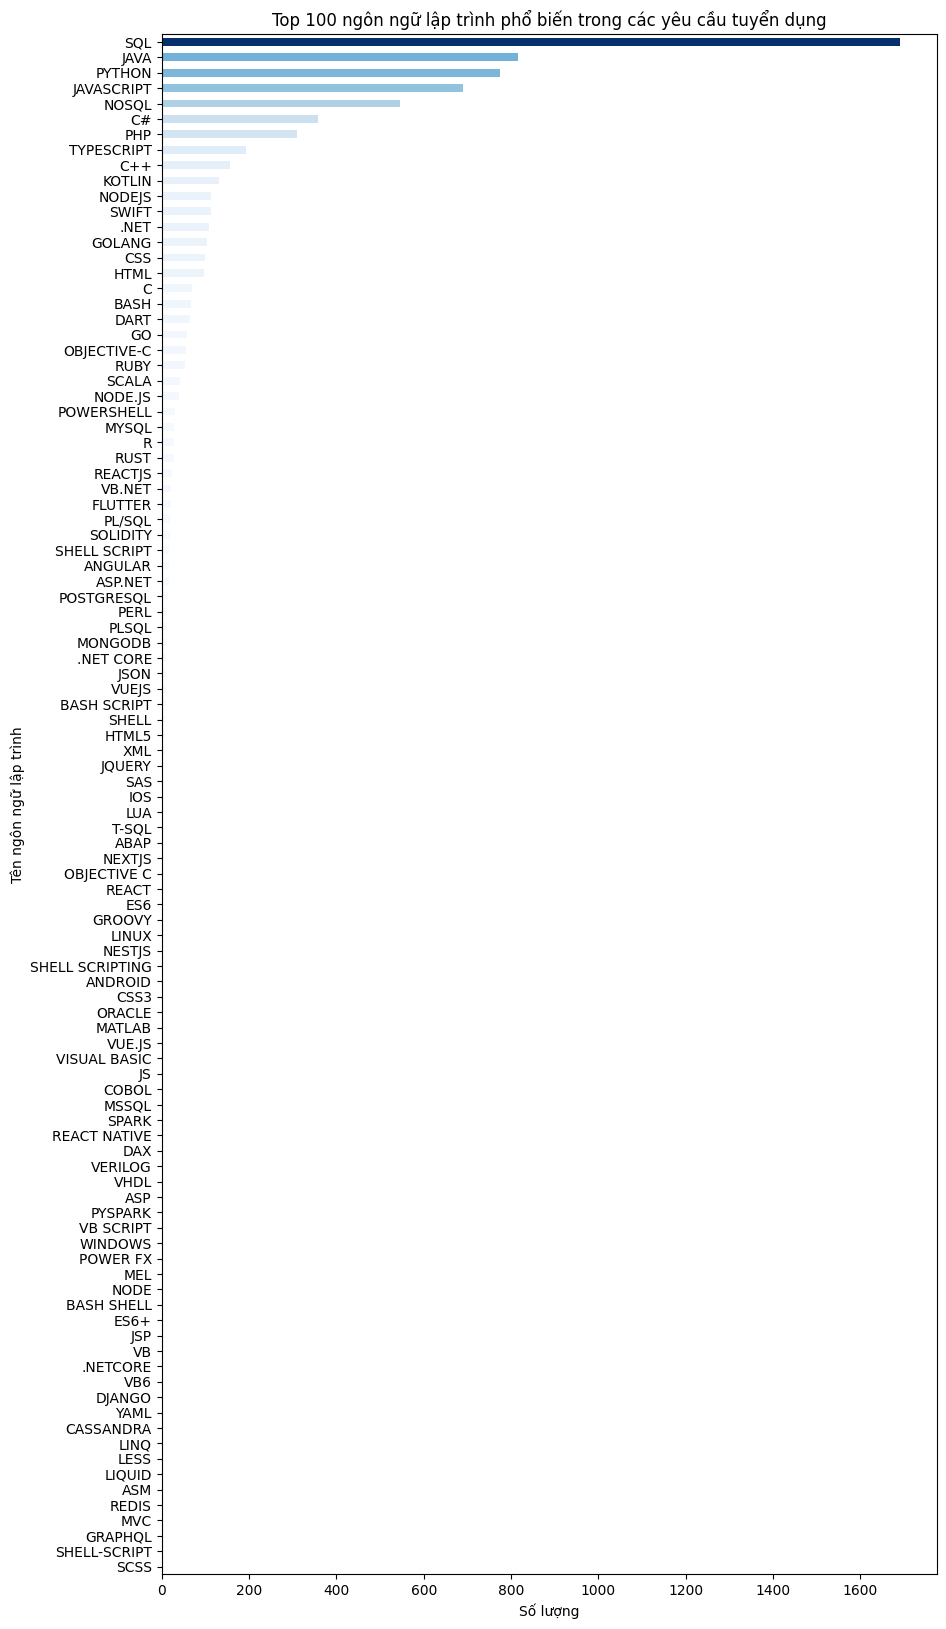

In [47]:
# Bước 1: Bỏ NaN
df_lang = df_final['Programming_Language'].dropna()

# Bước 2: Chuyển từ chuỗi dạng list → list thực (nếu cần)
df_lang = df_lang.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Bước 3: Gộp toàn bộ thành list lớn
all_langs = [lang for sublist in df_lang for lang in sublist]

# Bước 4: Đếm
lang_counts = pd.Series(Counter(all_langs)).sort_values(ascending=False)

# Lấy ra 100 Programming_Language phổ biến nhất
top_100_langs = lang_counts.nlargest(100).sort_values(ascending=True)

# Bước 5: Vẽ biểu đồ với thang màu
plt.figure(figsize=(10, 20))  # Điều chỉnh chiều cao để phù hợp với 100 mục

# Tạo thang màu dựa trên giá trị
colors = cm.Blues(top_100_langs / top_100_langs.max())  # Sử dụng thang màu 'Blues'

# Vẽ biểu đồ
top_100_langs.plot(kind='barh', color=colors)
plt.ylabel('Tên ngôn ngữ lập trình')
plt.xlabel('Số lượng')
plt.title('Top 100 ngôn ngữ lập trình phổ biến trong các yêu cầu tuyển dụng')
plt.show()

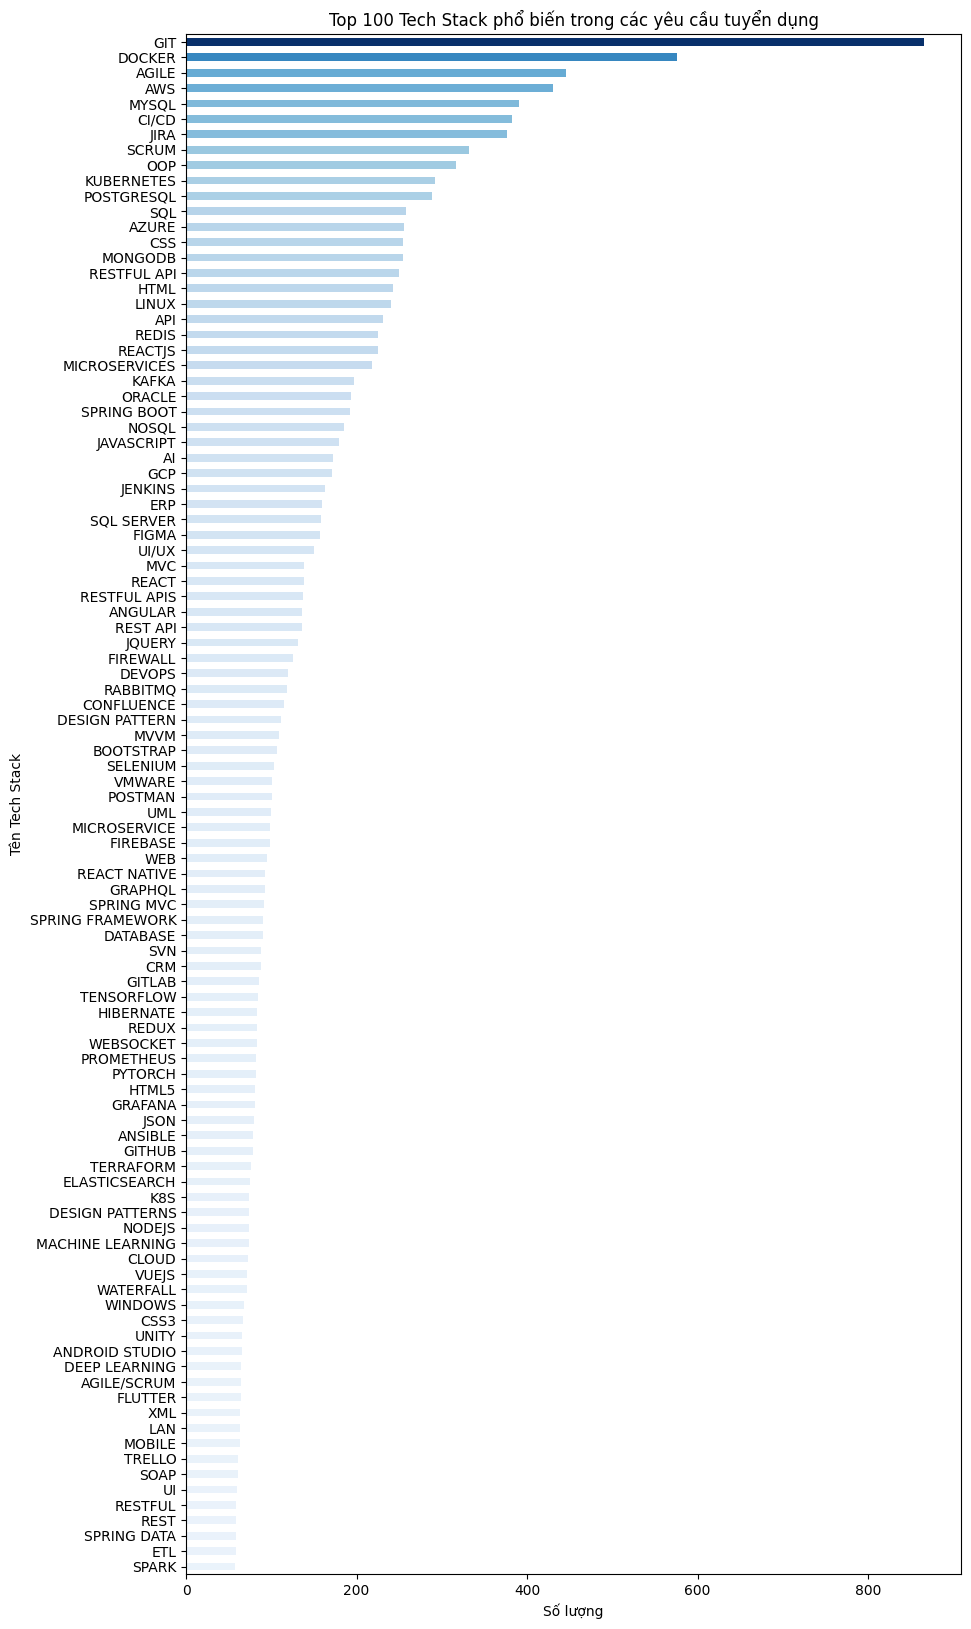

In [48]:
# Bước 1: Bỏ NaN
df_lang = df_final['Tech_Stack'].dropna()

# Bước 2: Chuyển từ chuỗi dạng list → list thực (nếu cần)
df_lang = df_lang.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Bước 3: Gộp toàn bộ thành list lớn
all_langs = [lang for sublist in df_lang for lang in sublist]

# Bước 4: Đếm
lang_counts = pd.Series(Counter(all_langs)).sort_values(ascending=False)

# Lấy ra 100 Tech Stack phổ biến nhất
top_100_langs = lang_counts.nlargest(100).sort_values(ascending=True)

# Bước 5: Vẽ biểu đồ với thang màu
plt.figure(figsize=(10, 20))  # Điều chỉnh chiều cao để phù hợp với 100 mục

# Tạo thang màu dựa trên giá trị
colors = cm.Blues(top_100_langs / top_100_langs.max())  # Sử dụng thang màu 'Blues'

# Vẽ biểu đồ
top_100_langs.plot(kind='barh', color=colors)
plt.ylabel('Tên Tech Stack')
plt.xlabel('Số lượng')
plt.title('Top 100 Tech Stack phổ biến trong các yêu cầu tuyển dụng')
plt.show()

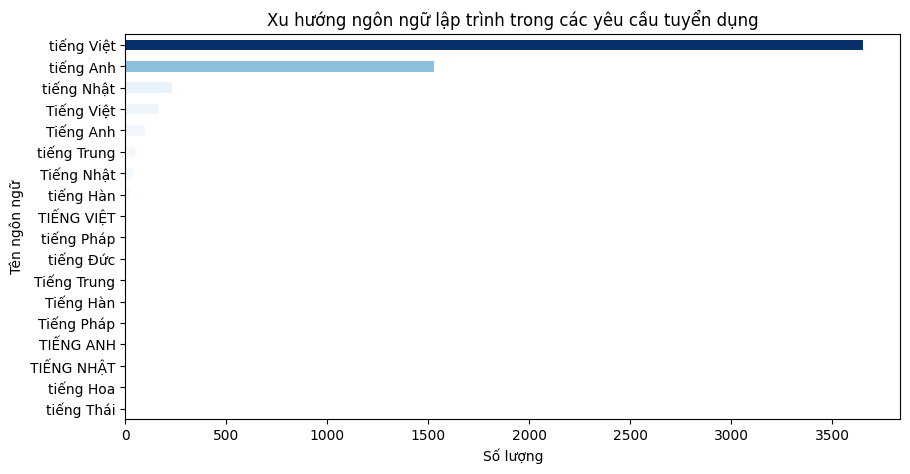

In [49]:
# Bước 1: Bỏ NaN
df_lang = df_final['Language'].dropna()

# Bước 2: Chuyển từ chuỗi dạng list → list thực (nếu cần)
df_lang = df_lang.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Bước 3: Gộp toàn bộ thành list lớn
all_langs = [lang for sublist in df_lang for lang in sublist]

# Bước 4: Đếm
lang_counts = pd.Series(Counter(all_langs)).sort_values(ascending=True)

# Bước 5: Vẽ biểu đồ với thang màu
plt.figure(figsize=(10, 5))

# Tạo thang màu dựa trên giá trị
colors = cm.Blues(lang_counts / lang_counts.max())  # Sử dụng thang màu 'Blues'

# Vẽ biểu đồ
lang_counts.plot(kind='barh', color=colors)
plt.ylabel('Tên ngôn ngữ')
plt.xlabel('Số lượng')
plt.title('Xu hướng ngôn ngữ lập trình trong các yêu cầu tuyển dụng')
plt.show()

In [50]:
# for i in range(len(data_original)):
#     print(data_original.iloc[i]['URL'])

# Kiểm tra lại bất thường trong dữ liệu ngày đi làm trong tuần 

In [51]:
test = pd.read_parquet(r'D:\Python_code\DS108_Đồ_án\API_code\standardized_data.parquet')
check = pd.DataFrame(columns=test.columns)  # Tạo DataFrame rỗng với các cột là các trường trong class Recruiment_Info


In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Job_Title                  4186 non-null   object 
 1   Tech_Stack                 3907 non-null   object 
 2   Programming_Language       2634 non-null   object 
 3   First_Working_Day_Of_Week  3717 non-null   Int64  
 4   Last_Working_Day_Of_Week   3717 non-null   Int64  
 5   Work_On_Saturday           3635 non-null   object 
 6   Work_On_Sunday             3609 non-null   object 
 7   Total_Work_Hour            3220 non-null   float64
 8   Province                   4186 non-null   object 
 9   Salary_Min                 1960 non-null   float64
 10  Salary_Max                 2361 non-null   float64
 11  Recruitment_Count          4186 non-null   Int64  
 12  Language                   4173 non-null   object 
 13  Job_Type                   4186 non-null   objec

In [53]:
#Hiển thị max số lượng cột 
pd.set_option('display.max_columns', None)

In [54]:
test.head(50)

,Job_Title,Tech_Stack,Programming_Language,First_Working_Day_Of_Week,Last_Working_Day_Of_Week,Work_On_Saturday,Work_On_Sunday,Total_Work_Hour,Province,Salary_Min,Salary_Max,Recruitment_Count,Language,Job_Type,Academic_Level,Experience_Years,Level,Company_Name,Company_Field,Company_URL,Deadline,Benefits,URL,Date_Crawl_Module_1,Role
0,Kỹ sư Cầu Nối Brse,None,None,2,6,False,False,40.00,[Hà Nội],NaN,NaN,1,"[tiếng Hàn, tiếng Anh, tiếng Việt]",Toàn thời gian,Đại Học trở lên,1 năm,Nhân viên,Công Ty TNHH LG CNS VIỆT NAM,IT - Phần mềm,https://www.topcv.vn/cong-ty/cong-ty-tnhh-lg-cns-viet-nam/139535.html,16/05/2025,"Attractive salary and bonus will be discussed after going through CV & Interview\r\nReview capacity annually and adjust salary increases according to work performance.\r\nHealth care: Premium health insurance, Annual health check-up\r\nYoung working environment\r\nGood career development opportunities with interesting and challenging projects.\r\nEnglish, Korean, technical, soft skills training courses.\r\nOpportunity to learn special courses from LG CNS, new technology and security.\r\nGifts on holidays (April 30th - May 1st, September 2nd, Tet, etc.)\r\nOutdoor activities with company support: sports clubs, team building, happy hour parties, birthdays, travel, employee and family events, etc.\r\nWorking hours: 8 hours from Monday - Friday (8:00 - 12:00 - 13:00 - 17:00)",https://www.topcv.vn/viec-lam/korean-bridge-software-engineer-ky-su-cau-noi-tieng-han/1696963.html?ta_source=ITJobs_LinkDetail,01/05/2025 20:38:51,Kỹ sư cầu nối BrSE
1,Network Technical Support Specialist,"[SWITCH, ROUTER, VPN, WIRELESS LAN CONTROLLER, ACCESS POINT, WIRELESS LAN SECURITY, WEP, WPA2, WPA3, LEAP, PEAP, CISCO, HPE, ARUBA, RUCKUS, HUAWEI, JUNIPER NETWORKS]",None,<NA>,<NA>,None,None,NaN,"[Bắc Ninh, Hà Nội, Bắc Giang]",NaN,NaN,1,"[Tiếng Anh, tiếng Trung]",Toàn thời gian,Cao Đẳng trở lên,3 năm,Nhân viên,CÔNG TY TNHH CÔNG NGHỆ ECOLIV,Bán lẻ - Hàng tiêu dùng - FMCG,https://www.topcv.vn/cong-ty/cong-ty-tnhh-cong-nghe-ecoliv/211293.html,17/05/2025,1. A 13th month salary as an end-of-year bonus\r\n2. Annual performance review for salary and career development\r\n3. Dynamic work environment with growth opportunities.\r\n4. Flexible working arrangements.\r\n5. Exposure to cutting-edge technologies and innovation.\r\n6. Professional development support and learning programs.,https://www.topcv.vn/viec-lam/network-technical-support-specialist/1632650.html?ta_source=ITJobs_LinkDetail,02/05/2025 08:41:43,Technical Leader
2,Gaming SOP Designer,[PHOTOSHOP],None,<NA>,<NA>,None,None,NaN,"[Đà Nẵng, Hà Nội]",10000000.0,13000000.0,1,[tiếng Việt],Toàn thời gian,Trung học phổ thông (Cấp 3) trở lên,1 năm,Nhân viên,CÔNG TY TNHH MTV NIA-STUDIO,IT - Phần mềm,https://www.topcv.vn/cong-ty/cong-ty-tnhh-mtv-nia-studio/147591.html,22/05/2025,Mức lương: thỏa thuận.\r\nLương tháng thứ 13\r\nCác chế độ khác theo quy định của nhà nước\r\nCơ hội phát triển và tham gia vào các dự án đa dạng.\r\nHỗ trợ các khóa đào tạo nâng cao kỹ năng,https://www.topcv.vn/viec-lam/gaming-sop-designer/1704685.html?ta_source=ITJobs_LinkDetail,02/05/2025 08:42:15,Game Developer
3,Lập Trình Viên Backend Java,"[SPRING BOOT, API, RESTFUL APIS, SOAP, GIT, SVN, ECLIPSE, INTELLIJ, NETBEANS, ORACLE, SQL, WEBFORM, MVC, ANGULAR, FINTECH, MICROSERVICE, CONTAINER, MESSAGE QUEUE, REDIS, KAFKA, KIỂM THỬ PHẦN MỀM (UNIT TESTING, INTEGRATION TESTING), DEVOPS CI/CD]","[JAVA, SQL]",2,6,False,False,47.50,[Hà Nội],16000000.0,32000000.0,5,[tiếng Việt],Toàn thời gian,Đại Học trở lên,3 năm,Nhân viên,Công ty Cổ phần SIMBATECH,IT - Phần mềm,https://www.topcv.vn/cong-ty/cong-ty-co-phan-simbatech/32829.html,30/06/2025,"CHẾ ĐỘ ĐÃI NGỘ:- Mức lương từ 16 – 32 triệu tùy level;- Hưởng lương tháng 13, xét tăng lương 6 tháng một lần, mức tăng tùy theo năng lực;- Được đóng đầy đủ bảo hiểm xã hội, bảo hiểm Y tế;- Được tham gia vào các dự án lớn của Ngân hàng, các Tổ chức tài chính lớn;- Môi trường công bằng, đảm bảo mọi người đều có thể 

## Kiểm tra miền giá trị của các thuộc tính ngày đi làm trong tuần


In [55]:
unique_first_working_days = test['First_Working_Day_Of_Week'].unique().tolist()
unique_last_working_days = test['Last_Working_Day_Of_Week'].unique().tolist()

print("Unique values of First_Working_Day_Of_Week:", unique_first_working_days)
print("Unique values of Last_Working_Day_Of_Week:", unique_last_working_days)

Unique values of First_Working_Day_Of_Week: [2, <NA>, 3, 1, 7]
Unique values of Last_Working_Day_Of_Week: [6, <NA>, 1, 5, 7]


In [56]:
#Kiểm tra các mẫu bất thường về ngày đi làm trong tuần
# test = df_extracted.copy() # Tạo bản sao của DataFrame đã trích xuất thông tin
# check = pd.DataFrame(columns=test.columns)  
# Kiểm tra nếu 'Job_Title' chứa một trong hai từ khóa "Triệu" hoặc "lương"
for i in range(len(test)):
    # if pd.notna(test.iloc[i]['Job_Title']) and any(keyword in test.iloc[i]['Job_Title'] for keyword in ['Triệu', 'Lương', 'Tiếng']):
    #     print(f"Row {i} contains 'Triệu' or 'Lương' in 'Job_Title':")
    if (pd.isna(test.iloc[i]['First_Working_Day_Of_Week']) and pd.notna(test.iloc[i]['Last_Working_Day_Of_Week'])) or (
        pd.notna(test.iloc[i]['First_Working_Day_Of_Week']) and (test.iloc[i]['First_Working_Day_Of_Week'] != 2)) or (
        (pd.notna(test.iloc[i]['First_Working_Day_Of_Week']) and pd.isna(test.iloc[i]['Last_Working_Day_Of_Week']))) or(
            pd.notna(test.iloc[i]['Last_Working_Day_Of_Week']) and (test.iloc[i]['Last_Working_Day_Of_Week'] != 6) or (
                test.iloc[i]['Work_On_Sunday'] == 1)
        ):
        check.loc[len(check)] = test.iloc[i]


## Các mẫu bất thường về thời gian làm việc trong tuần trong dữ liệu 

In [57]:
check

,Job_Title,Tech_Stack,Programming_Language,First_Working_Day_Of_Week,Last_Working_Day_Of_Week,Work_On_Saturday,Work_On_Sunday,Total_Work_Hour,Province,Salary_Min,Salary_Max,Recruitment_Count,Language,Job_Type,Academic_Level,Experience_Years,Level,Company_Name,Company_Field,Company_URL,Deadline,Benefits,URL,Date_Crawl_Module_1,Role
0,Deskside Support Engineer ( IT Support)_ IT Hcm,"[ITIL, DNS, DHCP, FIREWALL, VPN, CISCO, AVAYA, ACTIVE DIRECTORY, GROUP POLICY]",None,3,1,False,True,NaN,[Hồ Chí Minh],14000000.0,17000000.0,1,[tiếng Việt],Toàn thời gian,Trung cấp trở lên,Dưới 1 năm,Nhân viên,CÔNG TY TNHH TRANSCOSMOS VIỆT NAM,Null,https://www.topcv.vn/brand/chinhanhtranscosmoshochiminh?id=150239,Null,"Salary: Negotiate\r\nPromotion opportunities\r\nPeriodical bonus: twice/year\r\nPosition promotion, salary increase: once/year\r\n13th-month salary\r\nInsurances followed Vietnamese Labor Law\r\nBonuses, gifts for Holidays\r\nActivities: Birthday party, Employee engagement activities",https://www.topcv.vn/brand/chinhanhtranscosmoshochiminh/tuyen-dung/deskside-support-engineer-it-support-it-hcm-j1705536.html?ta_source=ITJobs_LinkDetail,01/05/2025 21:04:03,IT Helpdesk/IT support
1,Kỹ Thuật Viên Công Nghệ Thông Tin,"[FIREWALL, ROUTER, SWITCH, WIRELESS CONTROLLER, ACCESS POINT, PEPLINK, MẠNG MÁY TÍNH, KHẮC PHỤC SỰ CỐ PHẦN CỨNG, KHẮC PHỤC SỰ CỐ PHẦN MỀM, AN NINH MẠNG CƠ BẢN]",[SQL],2,6,True,True,NaN,[Hồ Chí Minh],NaN,NaN,5,[tiếng Việt],Toàn thời gian,Cao Đẳng trở lên,2 năm,Nhân viên,CÔNG TY TNHH SMYOU,IT - Phần cứng,https://www.topcv.vn/cong-ty/cong-ty-tnhh-smyou/61783.html,08/05/2025,"• BHXH đầy đủ theo quy định của nhà nước• Du lịch hàng năm cùng công ty• Lương tháng 13 • Nghỉ phép năm 12 ngày/ năm • Được tham gia các hoạt động trải nghiêm thực tế và đào tạo liên tục để nâng cao tay nghề• Xét duyệt tiêu chuẩn “ Học lái xe hơi” khi đạt các tiêu chuẩn trong công việc• Được hưởng chế độ Lập gia đình khi gắn bó từ 1 năm trở lên (mức chế độ: 10 – 50tr/ tùy vào khả năng đóng góp của nhân viên)• Xét chế độ con nhỏ (đối với NV có gia đình có con nhỏ): 1 -3tr/ bé• Môi trường làm việc được trang bị đầy đủ máy móc, trang thiết bị, thư viện, nhà ăn, chăm sóc sức khỏe, có tủ lạnh, nước uống đầy đủ.",https://www.topcv.vn/viec-lam/ky-thuat-vien-cong-nghe-thong-tin/1664279.html?ta_source=ITJobs_LinkDetail,01/05/2025 21:14:57,IT Helpdesk/IT support
2,Kỹ thuật viên Thợ Ép Kính Điện Thoại,"[IPHONE, ANDROID]",None,2,1,True,True,NaN,[Hồ Chí Minh],10000000.0,15000000.0,1,[tiếng Việt],Toàn thời gian,Trung cấp trở lên,Dưới 1 năm,Nhân viên,Hộ Kinh Doanh Sửa Chữa Bảo Hành 1 (One),Bảo trì / Sửa chữa,https://www.topcv.vn/cong-ty/ho-kinh-doanh-sua-chua-bao-hanh-1-one/213564.html,31/05/2025,"Tổng thu nhập : 10.000.000 – 15.000.000 VND / Tháng (Hưởng % Lợi nhuận đơn hàng)Hỗ trợ rủi ro sai sót quá trình thao tácThưởng Thái độ tác phong và trách nhiệm công việc hàng tháng, lương tháng 13. Công việc ổn định, LỘ TRÌNH TĂNG LƯƠNG HÀNG NĂMTham gia các khóa đào tạo kỹ năng mềm, định hướng chuyên môn phát triển bản thânĐược hưởng các phúc lợi khác theo quy định của Công tyNhận thưởng vào các ngày Lễ, Tết, sinh nhật....Được làm việc tại một trong những cửa hàng sửa điện thoại-laptop lớn nhất TPHCM",https://www.topcv.vn/viec-lam/ky-thuat-vien-tho-ep-kinh-dien-thoai/1650831.html?ta_source=ITJobs_LinkDetail,02/05/2025 20:53:08,IT Helpdesk/IT support
3,Kỹ thuật viên Sửa Điện Thoại Lương Cao,"[IPHONE, IPAD, SAMSUNG, SONY, HTC, LG, NOKIA, ASUS, ACER, LENOVO]",None,2,1,True,True,NaN,[Hồ Chí Minh],10000000.0,15000000.0,5,[tiếng Việt],Toàn thời gian,Trung cấp trở lên,1 năm,Nhân viên,Hộ Kinh Doanh Sửa Chữa Bảo Hành 1 (One),Bảo trì / Sửa chữa,https://www.topcv.vn/cong-ty/ho-kinh-doanh-sua-chua-bao-hanh-1-one/213564.html,31/05/2025,"Tổng Thu Nhập 10.000.000 - 15.000.000 VNĐ (Lương + thêm % Lợi nhuận đơn hàng doanh thu cá nhân)Hỗ trợ rủi ro sai sót quá trình thao tácThưởng Thái độ tác phong và trách nhiệm công việc hàng tháng, lương tháng 13. Công việc ổn định, LỘ TRÌNH TĂNG LƯƠNG HÀNG NĂMTh

## Đường link dẫn tới các thông tin tuyển dụng trong mục kiểm tra bất thường trong dữ liệu (biến check) 

In [58]:
list_bad_url = check['URL'].tolist() # Lấy danh sách các URL từ DataFrame
list_bad_url

['https://www.topcv.vn/brand/chinhanhtranscosmoshochiminh/tuyen-dung/deskside-support-engineer-it-support-it-hcm-j1705536.html?ta_source=ITJobs_LinkDetail',
 'https://www.topcv.vn/viec-lam/ky-thuat-vien-cong-nghe-thong-tin/1664279.html?ta_source=ITJobs_LinkDetail',
 'https://www.topcv.vn/viec-lam/ky-thuat-vien-tho-ep-kinh-dien-thoai/1650831.html?ta_source=ITJobs_LinkDetail',
 'https://www.topcv.vn/viec-lam/ky-thuat-vien-sua-dien-thoai-luong-cao/1652819.html?ta_source=ITJobs_LinkDetail',
 'https://www.topcv.vn/viec-lam/hoc-vien-sua-dien-thoai-may-tinh-bang/1654040.html?ta_source=ITJobs_LinkDetail',
 'https://www.topcv.vn/viec-lam/hoc-vien-sua-chua-va-thay-the-linh-kien-laptop/1654058.html?ta_source=ITJobs_LinkDetail',
 'https://www.topcv.vn/viec-lam/hoc-vien-sua-dien-thoai-may-tinh-bang/1654043.html?ta_source=ITJobs_LinkDetail',
 'https://www.topcv.vn/viec-lam/hoc-vien-sua-laptop-may-tinh-de-ban/1654061.html?ta_source=ITJobs_LinkDetail',
 'https://www.topcv.vn/viec-lam/it-service-desk/1

In [59]:
# fixed_samples = pd.DataFrame(columns=data_copy.columns)  # Tạo DataFrame rỗng với các cột là các trường trong class Recruiment_Info
# for i in range(len(data_copy)):
#     if data_copy.iloc[i]['URL'] in list_bad_url:
#         time.sleep(2.5) 
#         data_processed = extract_info(data_original.iloc[i], GOOGLE_API_KEY[len(GOOGLE_API_KEY) - 1]) # Gọi lại hàm extract_info với các dòng dữ liệu có URL trong danh sách list_bad_url
#         if data_processed:  # Kiểm tra nếu data_processed không phải None
#             # Cập nhật trực tiếp các cột trong data_copy
#             data_copy.at[i, 'Job_Title'] = data_processed['Job_Title']
#             data_copy.at[i, 'Tech_Stack'] = data_processed['Tech_Stack']
#             data_copy.at[i, 'Programming_Language'] = data_processed['Programming_Language']
#             data_copy.at[i, 'First_Working_Day_Of_Week'] = data_processed['First_Working_Day_Of_Week']
#             data_copy.at[i, 'Last_Working_Day_Of_Week'] = data_processed['Last_Working_Day_Of_Week']
#             data_copy.at[i, 'Work_On_Saturday'] = data_processed['Work_On_Saturday']
#             data_copy.at[i, 'Work_On_Sunday'] = data_processed['Work_On_Sunday']
#             data_copy.at[i, 'Total_Work_Hour'] = data_processed['Total_Work_Hour']
#             data_copy.at[i, 'Province'] = data_processed['Province']
#             data_copy.at[i, 'Salary_Min'] = data_processed['Salary_Min']
#             data_copy.at[i, 'Salary_Max'] = data_processed['Salary_Max']
#             data_copy.at[i, 'Recruitment_Count'] = data_processed['Recruitment_Count']
#             data_copy.at[i, 'Language'] = data_processed['Language']
#         fixed_samples.loc[len(fixed_samples)] = data_copy.iloc[i] # Thêm dòng dữ liệu đã sửa vào DataFrame fixed_samples

In [60]:
# fixed_samples

In [61]:
# data_copy['Work_On_Saturday'] = data_copy['Work_On_Saturday'].astype(bool)
# data_copy['Work_On_Sunday'] = data_copy['Work_On_Sunday'].astype(bool)
# data_copy.info()